In [51]:
from functions import *

NameError: name 'globallist' is not defined

In [3]:
#get pre-scraped text data

with open('rel_articles.txt', 'r') as file:
    data_code = file.read()

exec(data_code)  # Just to verify the content read

#get the data
with open('irrel_articles.txt', 'r') as file:
    data_code = file.read()

exec(data_code)  # Just to verify the content read



there are 12 articles in relevant_articles.
there are 11 articles in irrelevant_articles.


In [4]:
#### preprocess the data with our word_groups
for article in relevant_articles:
    article = rep_word_text(article, word_groups)
for article in irrelevant_articles:
    article = rep_word_text(article, word_groups)

# Training data (target)
labels = []
print(len(relevant_articles))
print(len(irrelevant_articles))
for i in range(len(relevant_articles)):
    labels.append('relevant')
for i in range(len(irrelevant_articles)):
    labels.append('irrelevant')

# Training data (independent variable)    
articles = relevant_articles + irrelevant_articles


12
11


In [5]:
#### The set of representative words
keywords = []
for word_group in word_groups:
    keywords.append(word_group[0])


In [ ]:
# How about removing countrie's name?
# What can be our bias?
# location / politics / 



### One thing we can do is filtering country related words!


def remove_country_words(text):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in countries]
    return ' '.join(filtered_words)
texts_filtered = [remove_country_words(text) for text in texts]


### TF-IDF vectorization

In [6]:
#### Vectorizing with the keywords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Initialize TF-IDF vectorizer with preselected keywords
#vectorizer = TfidfVectorizer(vocabulary=keywords)
vectorizer = TfidfVectorizer(stop_words='english')

# Compute TF-IDF scores for articles based on preselected keywords
tfidf_matrix = vectorizer.fit_transform(articles)

# Convert sparse TF-IDF matrix to dense array (for clustering)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [50]:
#### Split the articles into "training set" and "testing set".
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_dense, labels, test_size=0.2, random_state=432)


NameError: name 'tfidf_matrix_dense' is not defined

#### Warning: Because the number of articles are limited, the results highly depends on the training set

### Multinomial Naive Bayesian

In [24]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the classifier
clf = MultinomialNB()

# Train the classifier on the training data
clf.fit(X_train, y_train)


MultinomialNB()

In [33]:
feature_log_prob = clf.feature_log_prob_
feature_names = vectorizer.get_feature_names_out()

top_features = np.argsort(feature_log_prob[0])[::-1][:10]
#feature_names = np.array(feature_names)  # Assuming you have feature names
print("Top features for class 0:")
for feature_idx in top_features:
    print( feature_names[feature_idx], feature_log_prob[0][feature_idx])

Top features for class 0:
vessels -7.194048502934353
fishing -7.224364758820671
illegal -7.2969382812170185
crime -7.376714482946973
trade -7.39429404180946
fish -7.417072242498978
fisheries -7.438309623191769
thai -7.45517598987773
norwegian -7.456545746569475
iuu -7.456909403424468
kkp -7.526042436755371
illicit -7.5361699085489535
msc -7.53764102864624
trawler -7.53964504502903
fishery -7.552907827232975
somali -7.555114470756555
skylight -7.5797356769302455
unodc -7.5797356769302455
court -7.58335797364498
sydney -7.585327980984481


In [27]:
# Predict on the test data
y_pred = clf.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['relevant', 'irrelevant'], output_dict=True)
#print(report)
#print(type(report))


Accuracy: 1.00


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics
#class_names = list(report.keys())[:-3]  # Extract class names
class_names = ['relevant', 'irrelevant']
metrics = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}

for cls in class_names:
    metrics['precision'].append(report[cls]['precision'])
    metrics['recall'].append(report[cls]['recall'])
    metrics['f1-score'].append(report[cls]['f1-score'])
    metrics['support'].append(report[cls]['support'])

# Convert to numpy arrays for plotting
precision = np.array(metrics['precision'])
recall = np.array(metrics['recall'])
f1_score = np.array(metrics['f1-score'])
support = np.array(metrics['support'])


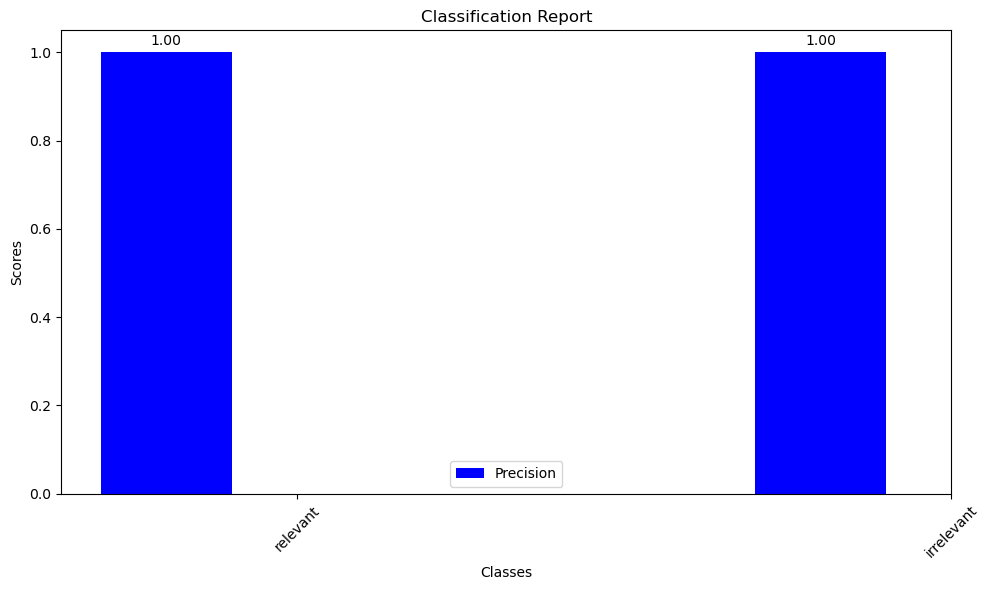

In [13]:
# Plotting the testing result
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(class_names))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='b')
#bar2 = ax.bar(index, recall, bar_width, label='Recall', color='g')
#bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1-score', color='r')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(index)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
#autolabel(bar2)
#autolabel(bar3)

plt.tight_layout()
plt.show()


### Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Predict labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


[[2 0]
 [0 3]]


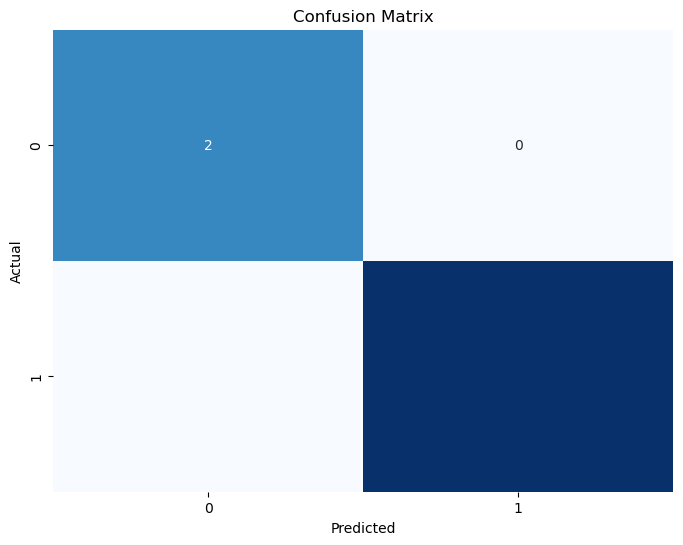

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [32]:
rel_precision = cm[0][0] / (cm[0][0]+cm[1][0])
irrel_precision = cm[1][1] / (cm[0][1]+cm[1][1])


42
75
291


### Classifying articles from our search

####  Import the articles from the file scraped_contents and concatenate Title and Content

#### Drop the rows with missing contents

In [48]:
import pandas as pd

# read the excel file
excel_data = pd.read_excel('scraped_contents.xlsx')

new_data = excel_data[['Query', 'Engine','Content']]

missing_content_ind = []
for ind, row in excel_data.iterrows():
    #print(type(row['Title']), row['Title'])
    #print(type(row['Content']))
    if (type(row['Content']) != str):
        #print("Missing content at index =", ind)
        missing_content_ind.append(ind)

    else:
        title_and_content = row['Title'] +  row['Content']  
        new_data.at[ind, 'Content'] = title_and_content 
        
print(missing_content_ind)

num_rows = len(new_data)

filtered_data = new_data.drop(missing_content_ind)

[42, 75, 291]


,Query,Engine,Content
40,Vessel caught falsifying fishing logs,Google,Investigation reveals Chinese seafood caught a...
41,Vessel caught falsifying fishing logs,Google,FACT CHECK: No reports of Taiwan attacking Chi...
43,Vessel caught falsifying fishing logs,Google,"Massachusetts Fishing Report- August 17, 2023 ..."
44,Vessel caught falsifying fishing logs,Google,"Reasons Why Deadliest Catch Is Fake \n""Deadlie..."
45,Vessel caught falsifying fishing logs,Google,Run & Gun: False Albacore Froth The Fisherman ...
